# Traffic light classifier
The notebook was written in [Google Colab](https://colab.research.google.com/), this allowed me to use their Tesla T4 gpu provided by google for better training time. I have selected a pretrained model from [Yolov5 family](https://github.com/ultralytics/yolov5). Specifically I used Yolov5s which is the lower end of the family. I used dataset provided by [Open Image V6](https://storage.googleapis.com/openimages/web/index.html).

# 1.) Downloading Yolo

In [5]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12122, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 12122 (delta 39), reused 52 (delta 26), pack-reused 12047
Receiving objects: 100% (12122/12122), 12.59 MiB | 31.21 MiB/s, done.
Resolving deltas: 100% (8327/8327), done.


# 2.) Authrizing Google Drive
Using google Drive to be my main directory and for storing datasets. (Dataset has already been uploaded to my google drive)

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 3.) Importing packages

In [3]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import time

# 4.) Limit GPU RAM (Optional)
This to prevent Cuda from using up all VRAM (Its only necessary if VRAM is limited)

In [21]:
torch.cuda.set_per_process_memory_fraction(0.5, 0)
torch.cuda.empty_cache()
total_memory = torch.cuda.get_device_properties(0).total_memory
# less than 0.5 will be ok:
tmp_tensor = torch.empty(int(total_memory * 0.499), dtype=torch.int8, device='cuda')
del tmp_tensor
torch.cuda.empty_cache()
# this allocation will raise a OOM:
#torch.empty(total_memory // 2, dtype=torch.int8, device='cuda')

RuntimeError: ignored

5.) Check if CUDA is enabled + GPU NAME (Optional)

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'Tesla T4'

# 5.) Train the model
In my case I chose those settings
image size: 480
batch size: 32
dataset size: 1024
epochs: 50

In [19]:
!cd yolov5 && python train.py --img 480 --batch 32 --epochs 250 --data dataset.yaml --weights yolov5s.pt --workers 10

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=250, batch_size=32, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=10, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-78-g5f1000a Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4

# 6.) Load the model


In [22]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp17/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-8-31 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7050580 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


Determining the accuracy of the model was obtained by checking the log file for expermint in my case the result folder was located: "/content/yolov5/runs/train/exp17/results.csv" in the result file in the last epoch, in the "metric/recision" row the model achived >0.9 prediction.

# 7.) Testing model

image 1/1: 576x1024 2 traffics
Speed: 14.3ms pre-process, 9.0ms inference, 1.1ms NMS per image at shape (1, 3, 384, 640)


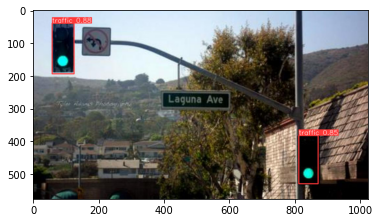

image 1/1: 683x1024 2 traffics
Speed: 35.9ms pre-process, 10.2ms inference, 1.2ms NMS per image at shape (1, 3, 448, 640)


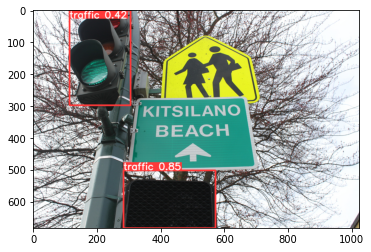

image 1/1: 769x1024 5 traffics
Speed: 228.9ms pre-process, 12.7ms inference, 1.2ms NMS per image at shape (1, 3, 512, 640)


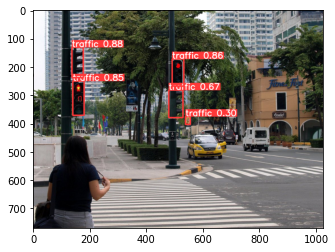

In [26]:
imgs = []
imgs.append(os.path.join('/content/drive/MyDrive/test', '2e969144f13eb1dc.jpg'))
imgs.append(os.path.join('/content/drive/MyDrive/test', '71c3eb3687efa946.jpg'))
imgs.append(os.path.join('/content/drive/MyDrive/test', 'd7deef955e16cc20.jpg'))

for path in imgs:
  results = model(path)
  results.print()
  %matplotlib inline 
  plt.imshow(np.squeeze(results.render()))
  plt.show()

# 7.) Conclusion

The Traffic light classifier was able to achieve around 90% accuracy based on the results.csv from the expermint. Determining the signal color can be achieved by two methods. first, We retrain the model on specific traffic light i.e green signals. This will allow the model to recoginize signal's color but could increase error rate. Second methd, applying further image processing to determine the dominat color in the boundy box to predict signal color.